## <font color='darkblue'>Preface</font>
([course link](https://realpython.com/python-matplotlib-guide/)) <b><font size='3ptx'>A picture is worth a thousand words, and with Python’s [matplotlib](https://matplotlib.org/) library, it fortunately takes far less than a thousand words of code to create a production-quality graphic.</font></b>

However, matplotlib is also a massive library, and getting a plot to look just right is often achieved through trial and error. <b>Using one-liners to generate basic plots in matplotlib is fairly simple, but skillfully commanding the remaining 98% of the library can be daunting</b>.

<b>This article is a beginner-to-intermediate-level walkthrough on matplotlib that mixes theory with examples</b>. While learning by example can be tremendously insightful, it helps to have even just a surface-level understanding of the library’s inner workings and layout as well.

Here’s what we’ll cover:
* Pylab and pyplot: which is which?
* Key concepts of matplotlib’s design
* Understanding `plt.subplots()`
* Visualizing arrays with matplotlib
* Plotting with the pandas + matplotlib combination

## <font color='darkblue'>Why Can Matplotlib Be Confusing?</font>
Learning matplotlib can be a frustrating process at times. The problem is not that matplotlib’s documentation is lacking: the documentation is actually extensive. But the following issues can cause some challenges:
* The library itself is huge, at something like 70,000 total lines of code.
* Matplotlib is home to several different interfaces (<font color='brown'>ways of constructing a figure</font>) and capable of interacting with a handful of different backends. (<font color='brown'>Backends deal with the process of how charts are actually rendered, not just structured internally.</font>)
* While it is comprehensive, some of matplotlib’s own public documentation is seriously [out-of-date](https://matplotlib.org/users/shell.html). The library is still evolving, and many older examples floating around online may take 70% fewer lines of code in their modern version.

So, before we get to any glitzy examples, it’s useful to grasp the core concepts of matplotlib’s design.

## <font color='darkblue'>Pylab: What Is It, and Should I Use It?</font>
Let’s start with a bit of history: John D. Hunter, a neurobiologist, began developing matplotlib around 2003, originally inspired to emulate commands from Mathworks’ [MATLAB](https://realpython.com/matlab-vs-python/) software. John passed away tragically young at age 44, in 2012, and matplotlib is now a full-fledged community effort, developed and maintained by a host of others. (<font color='brown'>John gave a [talk](https://www.youtube.com/watch?v=e3lTby5RI54) about the evolution of matplotlib at the 2012 SciPy conference, which is worth a watch.</font>)

One relevant feature of MATLAB is its global style. The Python concept of importing is not heavily used in MATLAB, and most of MATLAB’s [functions](https://www.mathworks.com/help/matlab/functionlist.html) are readily available to the user at the top level.

Knowing that matplotlib has its roots in MATLAB helps to explain why pylab exists. <b>pylab is a module within the matplotlib library that was built to mimic MATLAB’s global style. It exists only to bring a number of functions and classes from both NumPy and matplotlib into the [namespace](https://docs.python.org/3/tutorial/classes.html#python-scopes-and-namespaces), making for an easy transition for former MATLAB users who were not used to needing import statements</b>.

Ex-MATLAB converts (<font color='brown'>who are all fine people, I promise!</font>) liked this functionality, because with `from pylab import *`, they could simply call `plot()` or `array()` directly, as they would in MATLAB.

The issue here may be apparent to some Python users: using `from pylab import *` in a session or script is generally bad practice. Matplotlib now directly advises against this in its own tutorials:
> “[pylab] still exists for historical reasons, but it is highly advised not to use. It pollutes namespaces with functions that will shadow Python built-ins and can lead to hard-to-track bugs. To get IPython integration without imports the use of the %matplotlib magic is preferred.” [Source](https://matplotlib.org/users/shell.html#using-matplotlib-in-a-python-shell)

<br/>

<b>The bottom line is that matplotlib has abandoned this convenience module and now explicitly recommends against using pylab, bringing things more in line with one of Python’s key notions: explicit is better than implicit</b>.

Without the need for pylab, we can usually get away with just one canonical import:

In [1]:
import matplotlib.pyplot as plt

While we’re at it, let’s also import NumPy, which we’ll use for generating data later on, and call <font color='blue'>np.random.seed()</font> to make examples with (<font color='brown'>pseudo</font>) random data reproducible:

In [2]:
import numpy as np

np.random.seed(444)

## <font color='darkblue'>The Matplotlib Object Hierarchy</font>
<b><font size='3ptx'>One important big-picture matplotlib concept is its object hierarchy.</font></b>

If you’ve worked through any introductory matplotlib tutorial, you’ve probably called something like `plt.plot([1, 2, 3])`. This one-liner hides the fact that <b>a plot is really a hierarchy of nested Python objects. A “hierarchy” here means that there is a tree-like structure of matplotlib objects underlying each plot</b>.

<b>A <font color='darkblue'>Figure</font> object is the outermost container for a matplotlib graphic, which can contain multiple Axes objects</b>. One source of confusion is the name: an Axes actually translates into what we think of as an individual plot or graph (<font color='brown'>rather than the plural of “axis,” as we might expect</font>).

<b>You can think of the <font color='darkblue'>Figure</font> object as a box-like container holding one or more Axes</b> (<font color='brown'>actual plots</font>). Below the Axes in the hierarchy are smaller objects such as tick marks, individual lines, legends, and text boxes. Almost every “element” of a chart is its own manipulable Python object, all the way down to the ticks and labels:
![Figure vs Axes](images/1.PNG)


Here’s an illustration of this hierarchy in action. Don’t worry if you’re not completely familiar with this notation, which we’ll cover later on:

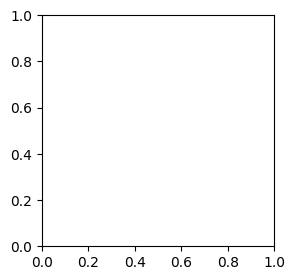

In [5]:
plt.rcParams['figure.figsize'] = [3, 3]
fig, _ = plt.subplots()

In [4]:
type(fig)

matplotlib.figure.Figure

Above, we created two variables with <font color='blue'>plt.subplots()</font>. The first is a top-level [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) object. The second is a “throwaway” variable that we don’t need just yet, denoted with an underscore. Using attribute notation, it is easy to traverse down the figure hierarchy and see the first tick of the y axis of the first [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) object:

In [6]:
one_tick = fig.axes[0].yaxis.get_major_ticks()[0]
type(one_tick)

matplotlib.axis.YTick

Above, `fig` (<font color='brown'>a [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) class instance</font>) has multiple [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) (<font color='brown'>a list, for which we take the first element</font>). Each[**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) has a yaxis and xaxis, each of which have a collection of “major ticks,” and we grab the first one.

Matplotlib presents this as a figure anatomy, rather than an explicit hierarchy:
![Figure hierarchy](images/2.PNG)

## <font color='darkblue'>Stateful Versus Stateless Approaches</font>
<b><font size='3ptx'>Alright, we need one more chunk of theory before we can get around to the shiny visualizations: the difference between the stateful (<font color='brown'>state-based, state-machine</font>) and stateless ([object-oriented](https://realpython.com/python3-object-oriented-programming/), OO) interfaces.</font></b>

Above, we used `import matplotlib.pyplot as plt` to import the pyplot module from matplotlib and name it `plt`.

Almost all functions from pyplot, such as `plt.plot()`, are implicitly either referring to an existing current [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) and current [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes), or creating them anew if none exist. Hidden in the matplotlib docs is this helpful snippet:
> “`[With pyplot]`, simple functions are used to add plot elements (lines, images, text, etc.) <b>to the current axes in the current figure</b>.” `[emphasis added]`

<br/>

Hardcore ex-MATLAB users may choose to word this by saying something like, “`plt.plot()` is a state-machine interface that implicitly tracks the current figure!” In English, this means that:
* The stateful interface makes its calls with `plt.plot()` and other top-level pyplot functions. There is only ever one [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) or [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) that you’re manipulating at a given time, and you don’t need to explicitly refer to it.
* Modifying the underlying objects directly is the object-oriented approach. We usually do this by calling methods of an [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) object, which is the object that represents a plot itself.

<br/>

The flow of this process, at a high level, looks like this:
![Figure hierarchy](images/3.PNG)

Tying these together, most of the functions from pyplot also exist as methods of the [**matplotlib.axes.Axes class**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes). This is easier to see by peeking under the hood. <font color='blue'>plt.plot()</font> can be boiled down to five or so lines of code:
```python
# matplotlib/pyplot.py
>>> def plot(*args, **kwargs):
...     """An abridged version of plt.plot()."""
...     ax = plt.gca()
...     return ax.plot(*args, **kwargs)

>>> def gca(**kwargs):
...     """Get the current Axes of the current Figure."""
...     return plt.gcf().gca(**kwargs)
```

<br/>

Calling `plt.plot()` is just a convenient way to get the current [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) of the current [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) and then call its <font color='blue'>plot()</font> method. This is what is meant by the assertion that the stateful interface always “implicitly tracks” the plot that it wants to reference.

pyplot is home to a [batch of functions](https://matplotlib.org/api/pyplot_summary.html#the-pyplot-api) that are really just wrappers around matplotlib’s object-oriented interface. For example, with <font color='blue'>plt.title()</font>, there are corresponding setter and getter methods within the OO approach, <font color='blue'>ax.set_title()</font> and <font color='blue'>ax.get_title()</font>. (<font color='brown'>Use of getters and setters tends to be more popular in languages such as Java but is a key feature of matplotlib’s OO approach.</font>)

Calling <font color='blue'>plt.title()</font> gets translated into this one line: <font color='blue'>gca().set_title(s, *args, **kwargs)</font>. Here’s what that is doing:
* <font color='blue'>gca()</font> grabs the current axis and returns it.
* <font color='blue'>set_title()</font> is a setter method that sets the title for that [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) object. The “convenience” here is that we didn’t need to specify any [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) object explicitly with <font color='blue'>plt.title()</font>.


Similarly, if you take a few moments to look at the source for top-level functions like [plt.grid()](https://github.com/matplotlib/matplotlib/blob/master/lib/matplotlib/pyplot.py#L3708), [plt.legend()](https://github.com/matplotlib/matplotlib/blob/master/lib/matplotlib/pyplot.py#L3714), and [plt.ylabels()](https://github.com/matplotlib/matplotlib/blob/master/lib/matplotlib/pyplot.py#L1521), you’ll notice that all of them follow the same structure of delegating to the current [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) with <font color='blue'>gca()</font> and then calling some method of the current [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes). (<font color='brown'>This is the underlying object-oriented approach!</font>)

## <font color='darkblue'>Understanding `plt.subplots()` Notation</font>
<b><font size='3ptx'>Alright, enough theory. Now, we’re ready to tie everything together and do some plotting.</font></b>

<b>From here on out, we’ll mostly rely on the stateless</b> (<font color='brown'>object-oriented</font>) <b>approach</b>, which is more customizable and comes in handy as graphs become more complex. The prescribed way to create a [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) with a single [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) under the OO approach is (<font color='brown'>not too intuitively</font>) with <font color='blue'>plt.subplots()</font>. This is really the only time that the OO approach uses pyplot, to create a [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) and [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes):

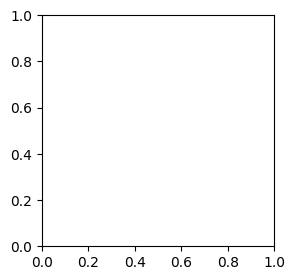

In [8]:
fig, ax = plt.subplots()

Above, we took advantage of iterable unpacking to assign a separate variable to each of the two results of [plt.subplots()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html#matplotlib.pyplot.subplots). Notice that we didn’t pass arguments to [subplots()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html#matplotlib.pyplot.subplots) here. The default call is <font color='blue'>subplots(nrows=1, ncols=1)</font>. Consequently, `ax` is a single <b><font color='blue'>AxesSubplot</font></b> object:

In [9]:
type(ax)

matplotlib.axes._subplots.AxesSubplot

We can call its instance methods to manipulate the plot similarly to how we call pyplots functions. Let’s illustrate with a stacked area graph of three time series:

In [11]:
rng = np.arange(50)
rnd = np.random.randint(0, 10, size=(3, rng.size))
yrs = 1950 + rng

In [14]:
rnd

array([[3, 0, 7, 8, 3, 4, 7, 6, 8, 9, 2, 2, 2, 0, 3, 8, 0, 6, 6, 0, 3, 0,
        6, 7, 9, 3, 8, 7, 3, 2, 6, 9, 2, 9, 8, 9, 3, 2, 2, 8, 1, 5, 6, 7,
        6, 0, 0, 0, 0, 4],
       [8, 1, 9, 8, 5, 8, 9, 4, 6, 6, 4, 1, 8, 2, 7, 9, 3, 4, 2, 5, 0, 0,
        8, 1, 0, 9, 9, 3, 2, 7, 6, 0, 5, 5, 4, 8, 3, 4, 9, 4, 7, 1, 5, 4,
        4, 0, 2, 2, 5, 8],
       [5, 6, 6, 1, 1, 6, 8, 4, 1, 0, 9, 2, 3, 7, 3, 3, 2, 7, 8, 6, 6, 7,
        5, 7, 3, 9, 1, 3, 0, 4, 7, 5, 1, 5, 1, 4, 9, 7, 2, 4, 3, 7, 9, 2,
        2, 0, 1, 5, 2, 4]])

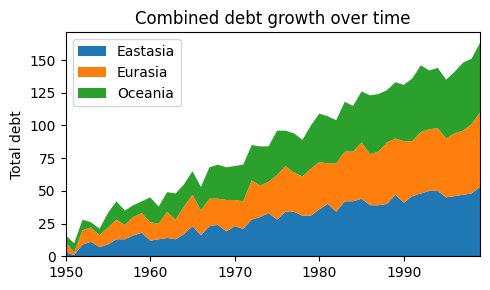

In [16]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.stackplot(yrs, rng + rnd, labels=['Eastasia', 'Eurasia', 'Oceania'])
ax.set_title('Combined debt growth over time')
ax.legend(loc='upper left')
ax.set_ylabel('Total debt')
ax.set_xlim(xmin=yrs[0], xmax=yrs[-1])
fig.tight_layout()

Here’s what’s going on above:
* After creating three random time series, we defined one [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) (`fig`) containing one [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) (a plot, `ax`).
* We call methods of `ax` directly to create a stacked area chart and to add a legend, title, and y-axis label. Under the object-oriented approach, it’s clear that all of these are attributes of `ax`.
* <font color='blue'>tight_layout()</font> applies to the [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) object as a whole to clean up whitespace padding.


Let’s look at an example with multiple subplots (Axes) within one Figure, plotting two correlated arrays that are drawn from the discrete uniform distribution:

In [18]:
x = np.random.randint(low=1, high=11, size=50)
y = x + np.random.randint(1, 5, size=x.size)
y

array([ 6,  2,  7,  7,  9,  5, 12,  4, 11,  7,  4, 10,  5,  7,  8,  9,  8,
        9,  7,  5, 11,  6,  5,  9,  6,  7,  4,  4,  8, 10,  9, 11, 10,  6,
        9, 11,  5,  3,  6,  5, 12,  4,  4, 11,  9,  8,  5,  7, 13, 10])

In [21]:
x

array([ 5,  1,  4,  3,  7,  1, 10,  1,  9,  5,  1,  7,  4,  3,  6,  7,  5,
        7,  6,  2, 10,  2,  2,  5,  3,  5,  2,  3,  6,  6,  8,  8,  8,  4,
        7,  7,  1,  1,  5,  4,  9,  3,  3,  7,  5,  7,  1,  3, 10,  7])

In [20]:
data = np.column_stack((x, y))
data[:10]

array([[ 5,  6],
       [ 1,  2],
       [ 4,  7],
       [ 3,  7],
       [ 7,  9],
       [ 1,  5],
       [10, 12],
       [ 1,  4],
       [ 9, 11],
       [ 5,  7]])

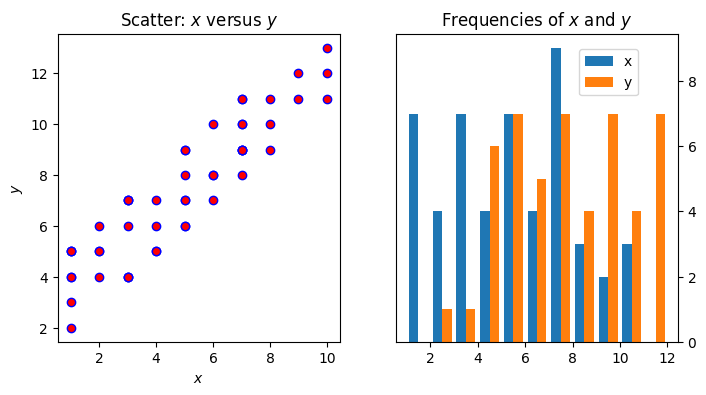

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax1.scatter(x=x, y=y, marker='o', c='r', edgecolor='b')
ax1.set_title('Scatter: $x$ versus $y$')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

ax2.hist(data, bins=np.arange(data.min(), data.max()), label=('x', 'y'))
ax2.legend(loc=(0.65, 0.8))
ax2.set_title('Frequencies of $x$ and $y$')
ax2.yaxis.tick_right()

There’s a little bit more going on in this example:
* Because we’re creating a “1x2” Figure, the returned result of <font color='blue'>plt.subplots(1, 2)</font> is now a [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) object and a NumPy array of [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) objects. (<font color='brown'>You can inspect this with `fig, axs = plt.subplots(1, 2)` and taking a look at axs.</font>)
* We deal with `ax1` and `ax2` individually, which would be difficult to do with the stateful approach. The final line is a good illustration of the object hierarchy, where we are modifying the yaxis belonging to the second Axes, placing its ticks and ticklabels to the right.
* Text inside dollar signs utilizes [TeX markup](https://en.wikipedia.org/wiki/TeX) to put variables in italics.

<br/>

Remember that multiple [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) can be enclosed in or “belong to” a given figure. In the case above, fig.axes gets us a list of all the [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) objects:

In [24]:
(fig.axes[0] is ax1, fig.axes[1] is ax2)

(True, True)

Taking this one step further, we could alternatively create a figure that holds a 2x2 grid of [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) objects: